In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../..")


import neuroprob as mdl
from neuroprob import utils

import utils_func

dev = utils.pytorch.get_device()

PyTorch version: 1.7.1+cu101
Using device: cuda:0


This notebook contains classical analysis of linear track data.

In [2]:
import os
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis\\notebook\\CA_precession'

In [4]:
os.chdir('..')
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis'

### Loading data

In [3]:
# loading data
dataset = 'hc3'
session_id = 'ec014.468'

data = np.load('./saves/{}_{}.npz'.format(dataset, session_id))
spktrain = data['spktrain']
x_t = data['x_t']
y_t = data['y_t']
hd_t = data['hd_t']
theta_t = data['theta_t']
eeg_t = data['eeg_t']
sample_bin = data['sample_bin']

units = spktrain.shape[0]

In [4]:
left_x = x_t.min()
right_x = x_t.max()
bottom_y = y_t.min()
top_y = y_t.max()

arena_width = right_x - left_x
arena_height = top_y - bottom_y

track_samples = len(x_t)

In [5]:
vx_t = (x_t[1:]-x_t[:-1])/sample_bin
vy_t = (y_t[1:]-y_t[:-1])/sample_bin
vx_t = np.concatenate((vx_t, vx_t[-1:]))
vy_t = np.concatenate((vy_t, vy_t[-1:]))
s_t = np.sqrt(vx_t**2 + vy_t**2)

In [6]:
sep_t_spike = []
for k in range(units):
    sep_t_spike.append(utils.neural.binned_to_indices(spktrain[k]))
    
ISI, LV = utils.neural.compute_ISI_LV(sample_bin, sep_t_spike) # compute ISIs and bursting coefficient

### Separate runs: L-R, R-L, stationary

In [9]:
c_x_t = utils_func.class_x_t(x_t)
dir_t = utils_func.L_R_run(c_x_t)
ind_L_R = np.where(dir_t == -1)
ind_R_L = np.where(dir_t == 1)
ind_stat = np.where(dir_t == 0)
print("% L_R ind: {}%".format(len(ind_L_R[0]) / len(dir_t)*100))
print("% R_L ind: {}%".format(len(ind_R_L[0]) / len(dir_t)*100))
print("% end/stationary ind: {}%".format(len(ind_stat[0]) / len(dir_t)*100))

# incompleted runs:  1
% L_R ind: 10.62406005172688%
% R_L ind: 13.714040059631877%
% end/stationary ind: 75.66189988864124%


### Select units

Select units by number of spikes and sparsity:

In [7]:
# binning of covariates and analysis
bins_x = 40
bins_y = int(arena_height/arena_width*bins_x)
bins_theta = 20

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

#corr_t_spikes = utils.neural.spike_threshold(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), sep_t_spike)
# selection of bins > 0.25 already happens in IPP_model here for convenience
# Mutual Informations
sp_rate, sp_prob = utils.neural.IPP_model(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), 
                                          sep_t_spike, divide=True)
sp_MI  = utils.neural.spike_var_MI(sp_rate, sp_prob)

sm_size = 5
sm_filter = np.ones((sm_size, sm_size)) / sm_size**2
smth_rate = utils.neural.smooth_hist(sp_rate, sm_filter, ['repeat', 'repeat'], dev='cpu')
coherence, sparsity = utils.neural.geometric_tuning(sp_rate, smth_rate, sp_prob) # coherence and sparsity of fields

In [10]:
n_spikes_L_R = np.sum(spktrain[:, ind_L_R], axis=(1, 2), dtype=int)
n_spikes_R_L = np.sum(spktrain[:, ind_R_L], axis=(1, 2), dtype=int)
n_spikes_stat = np.sum(spktrain[:, ind_stat], axis=(1, 2), dtype=int)

In [11]:
unit_discard = np.intersect1d(np.where(n_spikes_L_R < 200), np.where(n_spikes_R_L < 200))
print("# discarded units (< 200 spikes): ", len(unit_discard))
print(unit_discard)
unit_used = np.union1d(np.where(n_spikes_L_R > 200), np.where(n_spikes_R_L > 200))
print("Units left: ", len(unit_used))

# discarded units (< 200 spikes):  39
[ 2  6  7 13 15 16 17 18 19 22 23 27 29 30 32 40 45 46 47 48 49 50 52 54
 58 60 61 62 65 67 72 73 74 75 78 80 81 82 90]
Units left:  57


In [12]:
# Discard neurons if not sparse, enough (inhibitory neurons always ON)
unit_used = np.intersect1d(unit_used, np.argsort(sparsity)[18:])
print("Units left: ", len(unit_used))

Units left:  39


In [14]:
# delete some more if needed, chosen by histogram
del_mask = np.isin(unit_used, [5, 12, 25, 36, 39, 59, 76, 77, 85, 0, 8, 9, 24, 26, 28, 31, 35, 38, 51, 53, 57, 87, 88, 41])
unit_used = np.delete(unit_used, np.where(del_mask))
print("Units left: ", len(unit_used))

Units left:  15


In [16]:
# save reduced dataset
np.savez_compressed('./checkpoint/{}_{}_reduced.npz'.format(dataset, session_id), 
                    spktrain=spktrain[unit_used, :], x_t=x_t, y_t=y_t, hd_t=hd_t, 
                    theta_t=theta_t, eeg_t=eeg_t, sample_bin=sample_bin)

### Fit 2D GP

In [18]:
def heatmap_GP(rate_model, xlim, unit_used, xtheta_rate=None, eval_type='mean'):
    # run_type: 0 for L_R, 1 for R_L
    
    def make_func(neuron):
        def func_GP(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            theta = pos[1].flatten()
            covariates = [x, theta]
            lower, mean, upper = rate_model.eval_rate(covariates, [neuron], 'posterior')
            if eval_type == 'mean':
                return mean[0].reshape(*prevshape)
            elif eval_type == 'lower':
                return lower[0].reshape(*prevshape)
            elif eval_type == 'upper':
                return upper[0].reshape(*prevshape)
                
        return func_GP
    
    nrows = rate_model.out_dims
    ncols = 2 if xtheta_rate is not None else 1
    widths = [0.5] * ncols
    heights = [1] * nrows
    
    fig = plt.figure(figsize=(4*ncols, 3*nrows))

    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                             height_ratios=heights)#, left=0., right=0.2, bottom=0., top=1.)
    
    for neuron in range(rate_model.out_dims):
        if xtheta_rate is not None:
            grid_shape = [xlim, [0, 4*np.pi]]
            
            ax = fig.add_subplot(spec[neuron, 1])
            field = np.tile(xtheta_rate[neuron].T, (2,1)) # 0->0, 1->2 as 1 is stationary/end runs
            im = utils.plot.visualize_field((fig, ax), field, grid_shape, ticktitle='firing rate (Hz)', aspect='auto')

            ylabel = r'$\theta$'
            xlabel = r'$x$ (mm)'
            utils.plot.decorate_ax(ax, xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=[0, 4*np.pi],
                                  xticks=np.linspace(xlim[0], xlim[1], 3), yticks=[0, 2*np.pi, 4*np.pi],
                                  spines=[False, False, False, False])
            ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])
            ax.set_title("Histogram Neuron {}".format(unit_used[neuron]))
            vmax = np.max(field)
            
        
        grid_shape = [xlim, [0, 4*np.pi]]
        grid_size = [40, 30]

        ax = fig.add_subplot(spec[neuron, 0])
        _, field = utils.plot.compute_mesh(grid_size, grid_shape, make_func(neuron))
        im = utils.plot.visualize_field((fig, ax), field, grid_shape, ticktitle='firing rate (Hz)', aspect='auto') #, vmax=vmax)

        ylabel = r'$\theta$'
        xlabel = r'$x$ (mm)'
        utils.plot.decorate_ax(ax, xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=[0, 4*np.pi],
                          xticks=np.linspace(xlim[0], xlim[1], 3), yticks=[0, 2*np.pi, 4*np.pi],
                          spines=[False, False, False, False])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])
        ax.set_title("GP Neuron {}".format(unit_used[neuron]))
            
    plt.tight_layout(w_pad=1)
    plt.show()
    
    return fig

In [28]:
def setup_GP_2D(x_ts, theta_ts, spikes, left_x, right_x, dt, batch_size, lr):
    neurons, sim_samples = np.shape(spikes)
    
    ### GP KERNEL ###
    l_spat = 1.*np.array([np.ones(neurons)])
    l_ang = 0.1*np.array([np.ones(neurons)])
    v = np.ones(neurons)
    kernels_tuples = [('variance', v), ('Matern32', 'euclid', l_spat), ('Matern32', 'torus', l_ang)]
    
    ### INDUCING POINTS ###
    in_dims = 2
    num_induc = 20
    inducing_points = np.array([np.linspace(left_x, right_x, num_induc), 
                                np.random.rand(num_induc)*2*np.pi]).T[None, :, :].repeat(neurons, axis=0)
    # repeat to get separate inducing points per neuron

    ### GP MODEL ###
    rate_model = mdl.nonparametrics.Gaussian_process(
        in_dims, # input dimensions
        neurons, # number of neurons
        kernels_tuples, # kernels
        inducing_points=inducing_points, # initial inducing points
        mean=0.*np.ones((neurons)), # GP mean separate per neuron
        learn_mean=True, # learnable mean
        inv_link='exp', # inverse link function
        whiten=True, # use whitened representation
        jitter=1e-4 # jitter (numerical stability) 
    )

    ### LIKELIHOOD ###
    likelihood = mdl.likelihoods.Poisson(dt, neurons, 'exp')
    likelihood.set_Y(spikes, batch_size=batch_size, filter_len=1)

    ### INPUTS ###
    covariates = [x_ts.flatten(), utils.signal.WrapPi(theta_ts.flatten(), True)] # 0 to 2*pi
    VI_tuples = [(None, None, None, 1), (None, None, None, 1)] # no latent variables
    inputs = mdl.inference.input_group(in_dims, VI_tuples)
    inputs.set_XZ(covariates, resamples, batch_size=batch_size, filter_len=1)
   

    ### VI FRAMEWORK ###
    glm = mdl.inference.VI_optimized(inputs, rate_model, likelihood)
    glm.to(dev) # move to GPU if available

    # training parameters
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': lr}#, 'kernel.lengthscale': 5*1e-3}
    glm.set_optimizers(opt_tuple, opt_lr_dict)
    
    return rate_model, glm



def fit_GP_2D(x_ts, theta_ts, spikes, left_x, right_x, dt, batch_size, lr=1e-2):
    rate_model, glm = setup_GP_2D(x_ts, theta_ts, spikes, left_x, right_x, dt, batch_size, lr=lr)

    annealing = lambda x: 1.0#min(1.0, 0.001*x)
    losses = glm.fit(500, loss_margin=-1e0, margin_epochs=50, kl_anneal_func=annealing, 
                     cov_samples=1, ll_samples=10)

    plt.figure()
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('NLL per time sample')
    plt.show()
    
    return rate_model, glm

In [17]:
print("spktrain: ", np.shape(spktrain))
print("x_t: ", np.shape(x_t))
print("theta_t: ", np.shape(theta_t))

spktrain:  (96, 4877928)
x_t:  (4877928,)
theta_t:  (4877928,)


In [25]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = t-(r-a)  # free inside reserved
# print("Total: ", t/1e9)
print("Reserved: ", r/1e9)
print("Allocated: ", a/1e9)
print("Free: ", f/1e9)

Reserved:  0.96468992
Allocated:  3.584e-05
Free:  3.330313216


#### L-R GP

In [21]:
spktrain_L_R = np.squeeze(spktrain[unit_used][:,ind_L_R])
x_t_L_R = x_t[ind_L_R]
theta_t_L_R = theta_t[ind_L_R]

xleft = x_t_L_R.min()
xright = x_t_L_R.max()

bins_x = 40
bins_theta = 20

bin_x = np.linspace(xleft, xright+1e-3, bins_x+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

spiketimes = []
for s in spktrain_L_R:
    spiketimes.append(utils.neural.binned_to_indices(s))
xtheta_rate_L_R, _ = utils.neural.IPP_model(sample_bin, 0.0, (x_t_L_R, theta_t_L_R), (bin_x, bin_theta), 
                                                  spiketimes, divide=True)


print("For L_R runs:")
print("spktrain: ", np.shape(spktrain_L_R))
print("x_t: ", np.shape(x_t_L_R))
print("theta_t: ", np.shape(theta_t_L_R))

For L_R runs:
spktrain:  (39, 518234)
x_t:  (518234,)
theta_t:  (518234,)


In [22]:
# bin data
bin_size = 3 # 2.4 ms
tbin, resamples, spk_count_L_R, (rx_t_L_R, rtheta_t_L_R,) = utils.neural.bin_data(bin_size, sample_bin, spktrain_L_R, 
                                                        spktrain_L_R.shape[1], (x_t_L_R, theta_t_L_R), average_behav=False, binned=True)

print(resamples)

172744


In [29]:
rate_model_L_R, glm_L_R = fit_GP_2D(rx_t_L_R, rtheta_t_L_R, spk_count_L_R, \
                                    xleft, xright, dt=tbin, batch_size=int(1e5), lr=5*1e-2)
model_name_L_R = "GP_16resampled_L_R"
torch.save({'glm': glm_L_R.state_dict()}, './checkpoint/' + model_name_L_R)

KeyboardInterrupt: 

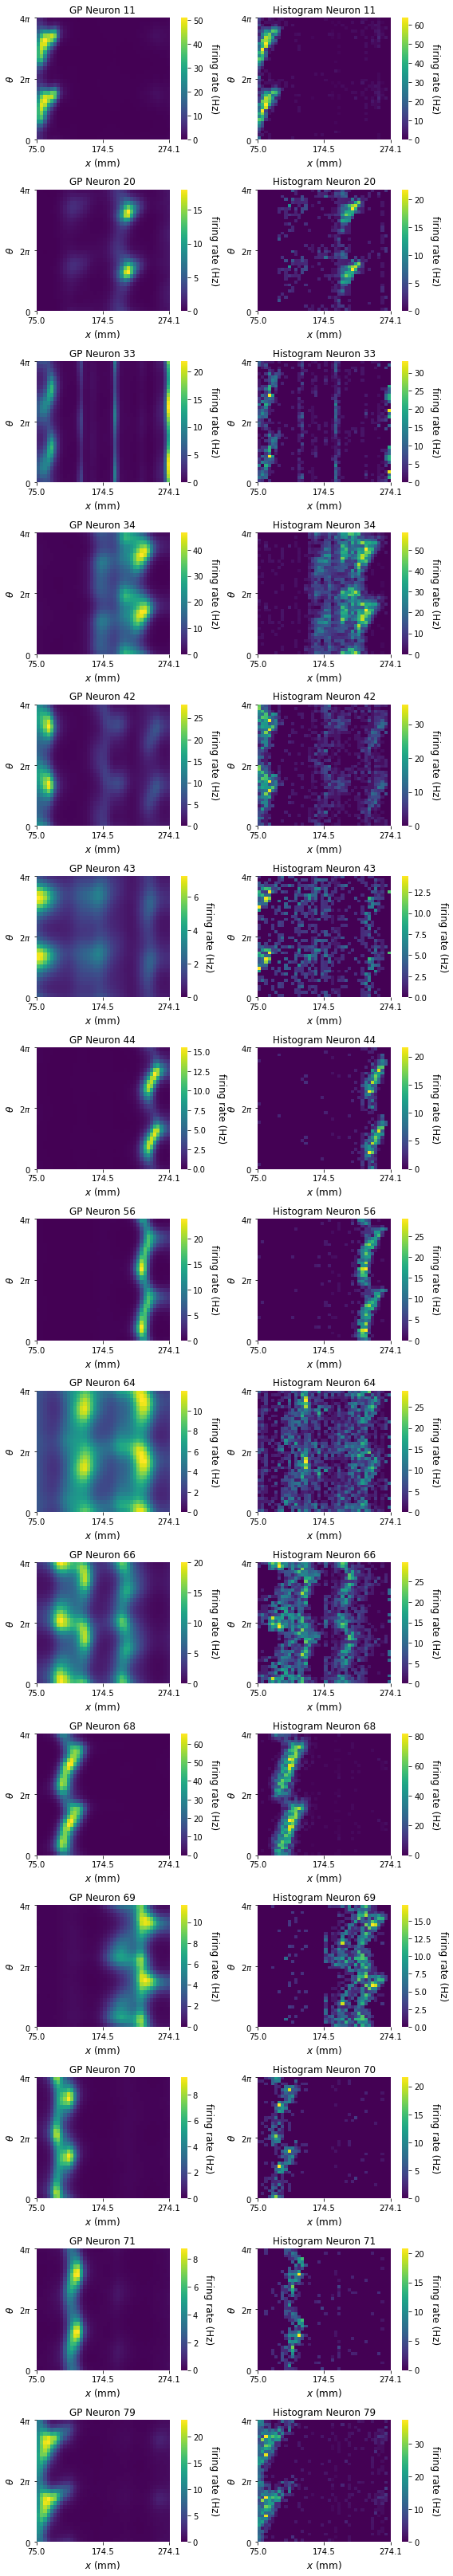

In [28]:
fig_L_R = heatmap_GP(rate_model_L_R, (xleft, xright), unit_used, xtheta_rate_L_R)

In [270]:
# load model
rate_model_L_R, glm_L_R = setup_GP_2D(x_t_L_R, theta_t_L_R, spktrain_L_R, n_runs=1, x_max=300, dt=sample_bin)
# CHANGE NAME
checkpoint = torch.load('./checkpoint/' + "GP_select15_L_R_S_l_spat")
glm_L_R.load_state_dict(checkpoint['glm'])

<All keys matched successfully>

In [274]:
# continue fitting
rate_model_L_R, glm_L_R = cfit_GP_2D(rate_model_L_R, glm_L_R)
model_name_L_R = "GP_select15_L_R_S_l_spat_cont"
torch.save({'glm': glm_L_R.state_dict()}, './checkpoint/' + model_name_L_R)

In [29]:
fig_L_R.savefig("output/" + model_name_L_R + ".svg", bbox_inches='tight')

#### R-L GP

In [32]:
spktrain_R_L = np.squeeze(spktrain[unit_used][:,ind_R_L])
x_t_R_L = x_t[ind_R_L]
theta_t_R_L = theta_t[ind_R_L]

xleft = x_t_R_L.min()
xright = x_t_R_L.max()

bins_x = 40
bins_theta = 20

bin_x = np.linspace(xleft, xright+1e-3, bins_x+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

spiketimes = []
for s in spktrain_R_L:
    spiketimes.append(utils.neural.BinToTrain(s))
xtheta_rate_R_L, _ = utils.neural.IPP_model(sample_bin, 0.0, (x_t_R_L, theta_t_R_L), (bin_x, bin_theta), 
                                                  spiketimes, divide=True)

print("For R_L runs:")
print("spktrain: ", np.shape(spktrain_R_L))
print("x_t: ", np.shape(x_t_R_L))
print("theta_t: ", np.shape(theta_t_R_L))

For R_L runs:
spktrain:  (15, 668961)
x_t:  (668961,)
theta_t:  (668961,)


In [33]:
# bin data
bin_size = 3 # 2.4 ms
tbin, resamples, spk_count_R_L, (rx_t_R_L, rtheta_t_R_L,) = utils.neural.BinTrain(bin_size, sample_bin, spktrain_R_L, 
                                                        spktrain_R_L.shape[1], (x_t_R_L, theta_t_R_L), average_behav=False, binned=True)

print(resamples)

222987


  0%|          | 0/500 [00:00<?, ?it/s]


Stopped at epoch 352.


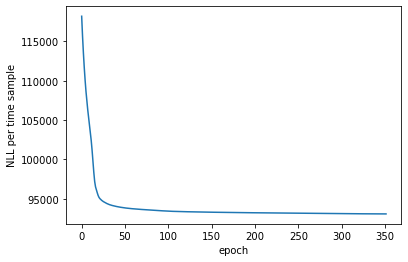

In [34]:
rate_model_R_L, glm_R_L = fit_GP_2D(rx_t_R_L, rtheta_t_R_L, spk_count_R_L, \
                                    xleft, xright, dt=tbin, batch_size=int(1e5), lr=5*1e-2)
model_name_R_L = "GP_16resampled_R_L"
torch.save({'glm': glm_R_L.state_dict()}, './checkpoint/' + model_name_R_L)

In [195]:
# load model
rate_model_R_L, glm_R_L = setup_GP_2D(x_t_R_L, theta_t_R_L, spktrain_R_L, n_runs=1, x_max=300, dt=sample_bin)
checkpoint = torch.load('./checkpoint/' + 'GP_select16_R_L')
glm_R_L.load_state_dict(checkpoint['glm'])

<All keys matched successfully>

In [277]:
# continue fitting
rate_model_R_L, glm_R_L = cfit_GP_2D(rate_model_R_L, glm_R_L)
model_name_R_L = "GP_select16_R_Lcont"
torch.save({'glm': glm_R_L.state_dict()}, './checkpoint/' + model_name_R_L)

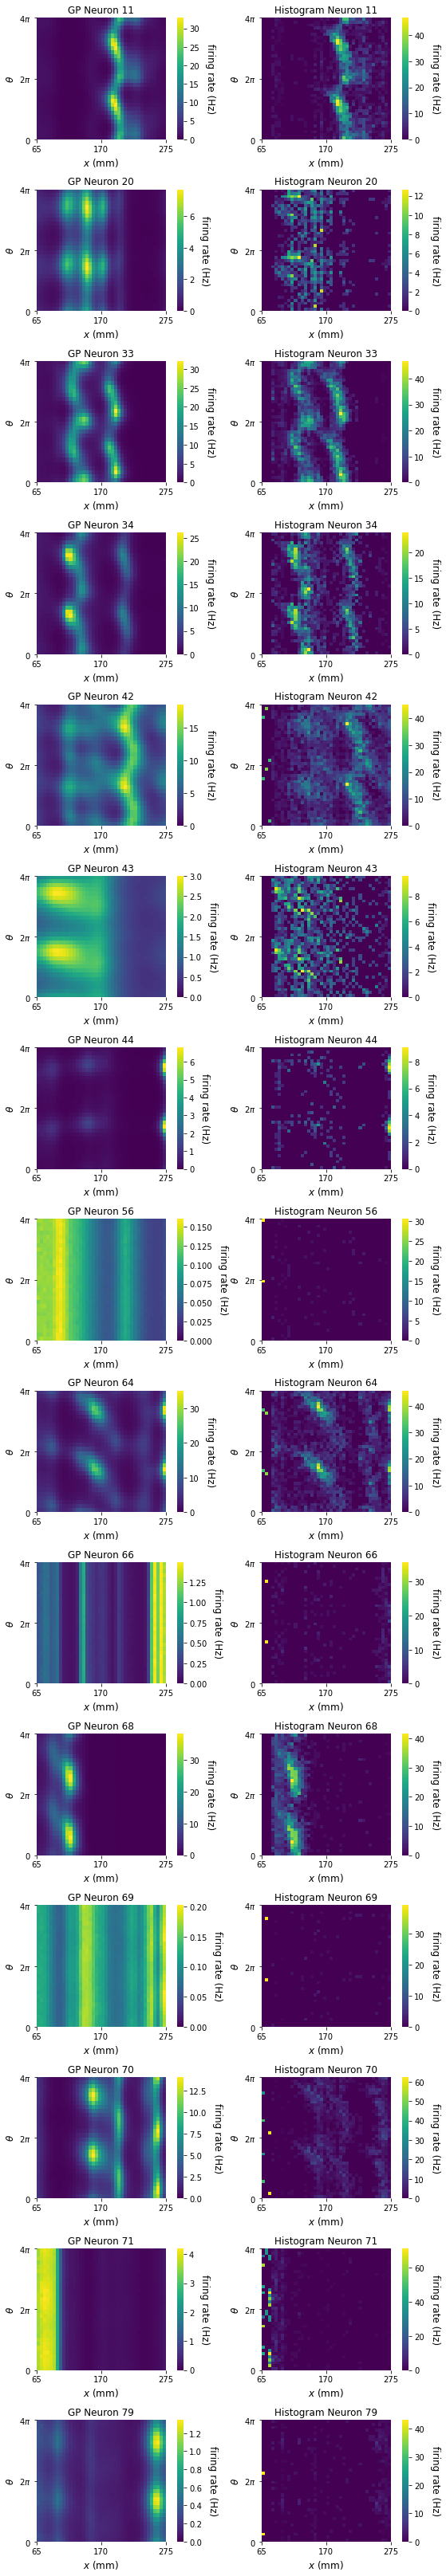

In [40]:
fig_R_L = heatmap_GP(rate_model_R_L, (xleft, xright), unit_used, xtheta_rate_R_L)

In [36]:
fig_R_L.savefig("output/" + model_name_R_L + "_vmax.svg", bbox_inches='tight')

### Calculating Phase Precession

In [279]:
# Draw GP samples

In [ ]:
"""
phase precession metric

Instead of time, spikes are now ordered along the theta axis (unwrapped), which warps their 
distances to the theta oscillations time flow. If there is precession, the spikes should be 
most correlated slightly before autocorrelation at 2 pi difference.
"""

u_theta_t = np.unwrap(theta_t) - theta_t[0]
u_theta_s, = neural_utils.CovariatesAtSpikes(sep_t_spike, (u_theta_t,))
theta_periods = int(u_theta_t.max() / (2*np.pi))+1

bins_per_period = 60
bin_theta = np.linspace(0, theta_periods*2*np.pi, theta_periods*bins_per_period+1)

# phase precession
lag_range = 100
theta_window = len(bin_theta)-1

spikes_theta = np.zeros((units, theta_window))
for u in range(units):
    theta_ind = np.digitize(u_theta_s[u], bin_theta)-1
    np.add.at(spikes_theta[u, :], theta_ind, 1)

u = 12
cg = neural_utils.spike_correlogram(spikes_theta[:u, :], 1, lag_range, 1800000, start_step=0, ref_point=0, cross=False, 
                                    correlation=False, dev='cpu')

In [ ]:
freq_low_limit = 5.
border = int(freq_low_limit/freq_bin) # bigger than 5 Hz

# FFT to get estimate of theta period
fourierTransform = np.fft.rfft2(cg, axes=(1,))
fourierTransform = fourierTransform[:, :int(lag_range/2)] # Nyquist
FP = np.abs(fourierTransform)**2

freq_bin = 1/bins_per_period
freq = np.arange(lag_range//2)*freq_bin

border = bins_per_period//2
relative_precess_freq = (np.argmax(FP[:, border:], axis=1)+border)*freq_bin
precess_index = relative_precess_freq - 1.
precess_amount = np.max(FP[:, border:], axis=1)/np.min(FP[:, border:], axis=1)

In [ ]:
print(precess_index)
print(precess_amount)